In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
np.set_printoptions(suppress=True) #no scientific notation
from scipy.stats import chi2_contingency
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [4]:
df = pd.read_csv(r"Geo Modified Dataset - 80 cells - width==0.1 .csv", index_col=(0,1))

race_set = set(['ASIAN', 'BLACK', 'HISPANIC', 'NATIVE AMERICAN', 'OTHER', 'WHITE'])
race_set_w_out_NA = set(['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE'])

# Define Necessary Functions

In [5]:
# CONDTIONAL_SPEED_CUTOFF = 15
# #note that this cutoff is INCLUSIVE

## Create a dataframe of raw stop count

e.g. raw_count_df['ASIAN'][10] = $\#\, asian \, stops\, at\, 10\, mph\,$

In [6]:
def generate_raw_count_df(dataframe, a, b):
    count_between_a_b_mph_intermediate_dict = {race:{x:0 for x in list(range(a, b+1))} for race in race_set}
    race_total_between_a_b_mph = {race:0 for race in race_set}

    #raw count of speeds 
    for x in list(zip(dataframe['Speed Over Posted Limit'], dataframe['Race'])):
        if a <= x[0] <= b:
            count_between_a_b_mph_intermediate_dict[x[1]][x[0]] += 1
            race_total_between_a_b_mph[x[1]] += 1
            
    return pd.DataFrame(count_between_a_b_mph_intermediate_dict)

## Create a dataframe of percentage stop count

e.g. pct_stop_df['ASIAN'][10] = $\frac{asian \, stops\, at\, 10\, mph\,}{\,all\, asian\, stops}$

In [7]:
def create_speed_pct_PDF(dataframe, a, b):
    """       
    a = min speed
    b = max speed
    
    returns pd dataframe of all races' speeds percentages at a certain speed
    
    note: the range is inclusive
    """
    count_between_a_b_mph_intermediate_dict = generate_raw_count_df(df, a, b)
    
    race_total_between_a_b_mph = {race: count_between_a_b_mph_intermediate_dict[race].sum() for race in race_set}
    
    percent_between_a_b_mph_df = pd.DataFrame({race: 100 * count_between_a_b_mph_intermediate_dict[race]/count_between_a_b_mph_intermediate_dict[race].sum() for race in race_set})
    
    return percent_between_a_b_mph_df

## ~~Return % leq a specific speed ~~(No longer needed)

In [8]:
# def pct_leq_n_mph(speeding_percentages_list, n):
    
#     """
#     INCLUSIVE range
    
#     n = specific speed
#     """
    
#     return sum([mph for i, mph in enumerate(speeding_percentages_list) if i <= n]) / sum([mph for mph in speeding_percentages_list]) #make it "i+a" if want a range starting at "a"

## Returns a dataframe with df[race][x] = % $\leq $ speed *x*

In [9]:
def generate_pct_CDF(speeding_percentages_df):
    
    return speeding_percentages_df.cumsum()

## Adds columns of differences between columns

In [13]:
def create_difference_between_races(speed_CDF):
    already_done = []

    for race in race_set_w_out_NA:
        for race2 in race_set_w_out_NA:
            if race != race2:
                if sorted([race, race2]) not in already_done:
                    
                    speed_CDF[f"{race} - {race2}"] = abs(speed_CDF[race] - speed_CDF[race2])
                    
                    already_done.append(sorted([race, race2]))


# Z-test for different distributions/means

## Function for z_test

In [16]:
def z_statistic(pct_CDF_df, raw_count_CDF_df, race1, race2, speed): #meant to be applied to speed_pct_CDF
    
    p1 = pct_CDF_df[race1][speed]/100
    p2 = pct_CDF_df[race2][speed]/100
    
    n1 = raw_count_CDF_df[race1][speed]
    n2 = raw_count_CDF_df[race2][speed]
    
    numerator = p1 - p2
    
    denominator = np.sqrt( (p1 * (1-p1))/n1 + (p2 * (1-p2))/n2 )
    
    return numerator / denominator

In [17]:
def create_z_stat_df(pct_CDF_df, raw_count_CDF_df, CONDTIONAL_SPEED_CUTOFF):#, CONFIDENCE):
    
    local_z_stat_df = pd.DataFrame()

    already_done = []

    for race in race_set_w_out_NA:
        for race2 in race_set_w_out_NA:
            if race != race2:
                if sorted([race, race2]) not in already_done:

                    local_z_stat_df[f"{race} - {race2}"] = [z_statistic(pct_CDF_df, raw_count_CDF_df, race, race2, n) for n in range(CONDTIONAL_SPEED_CUTOFF,101)]

                    already_done.append(sorted([race, race2]))

#     return local_z_stat_df.fillna(0).round(3)
#     local_z_stat_df[F"{CONFIDENCE}% CI Upper"] = norm.interval(CONFIDENCE)[1]
#     local_z_stat_df[F"{CONFIDENCE}% CI Lower"] = norm.interval(CONFIDENCE)[0]

    return adjust_index_by_cutoff(local_z_stat_df.fillna(0).round(3), CONDTIONAL_SPEED_CUTOFF)


# Combining Functions for Easy Running

In [19]:
def adjust_index_by_cutoff(df, cutoff):
    return df.set_index(df.index + cutoff)

In [115]:
def investigate_conditional_cutoff(speed):
    
    CONDTIONAL_SPEED_CUTOFF = speed
    
    raw_count_df = generate_raw_count_df(df, CONDTIONAL_SPEED_CUTOFF, 100)
    
    raw_count_cumulative_df = raw_count_df.cumsum()

    
    speed_pct_PDF = create_speed_pct_PDF(df, CONDTIONAL_SPEED_CUTOFF, 100)
    
    speed_pct_CDF = generate_pct_CDF(speed_pct_PDF)
    
    #plotting parameters
    mpl.rcParams['figure.dpi']= 150
    upper_mph = 30
    
    
    z_stat_df = create_z_stat_df(speed_pct_CDF, raw_count_cumulative_df, CONDTIONAL_SPEED_CUTOFF)
        
    speed_pct_CDF[:upper_mph][:30-CONDTIONAL_SPEED_CUTOFF].plot(title=f'Cumulative Sum (Percent) vs MPH - CUTOFF AT {speed} MPH') 

    z_stat_df[[col for col in z_stat_df.columns if 'WHITE' in col]][:upper_mph].plot(title=f'Test Statistic over MPH - CUTOFF AT {speed} MPH')
    z_stat_df[[col for col in z_stat_df.columns if 'WHITE' in col]][:23-CONDTIONAL_SPEED_CUTOFF].plot(title=f'Test Statistic over MPH - CUTOFF AT {speed} MPH')
    
    
    merged_CDF_z_stat_df= pd.concat([speed_pct_CDF, z_stat_df], axis=1)
    merged_CDF_z_stat_df.style.set_caption(f"Cutoff at {speed}")
    merged_CDF_z_stat_df= merged_CDF_z_stat_df.drop(columns=[col for col in merged_CDF_z_stat_df if 'WHITE' not in col and '-' in col])

    return merged_CDF_z_stat_df[:41-CONDTIONAL_SPEED_CUTOFF]

# Examine various cutoffs for evidence of equal conditional distributions

,WHITE,BLACK,HISPANIC,ASIAN,OTHER,NATIVE AMERICAN,WHITE - BLACK,WHITE - HISPANIC,WHITE - ASIAN,WHITE - OTHER
10,2.213491,2.663340,3.065349,1.997780,2.705718,9.433962,-0.432,-0.692,0.122,-0.278
11,2.750491,3.297148,3.761509,2.663707,3.430962,9.433962,-0.527,-0.824,0.049,-0.385
12,3.597468,4.241117,4.794521,3.440622,4.546722,15.094340,-0.623,-0.981,0.089,-0.541
13,4.850469,5.481761,6.119470,4.578246,5.774059,18.867925,-0.615,-1.047,0.156,-0.529
14,6.457105,7.073023,8.151808,6.548280,7.447699,18.867925,-0.605,-1.412,-0.053,-0.573
15,19.519756,17.894950,20.559174,19.256382,21.394700,32.075472,1.708,-0.932,0.164,-1.176
16,28.517791,26.168161,28.812037,28.579356,29.316597,35.849057,2.611,-0.279,-0.041,-0.529
17,36.882777,33.935675,36.683135,37.375139,38.075314,39.622642,3.471,0.201,-0.347,-0.843
18,44.444444,41.440227,44.329665,45.865705,46.108787,41.509434,3.763,0.123,-1.076,-1.260
19,56.970094,56.671836,57.073883,58.823529,59.386332,50.943396,0.430,-0.127,-1.607,-2.102


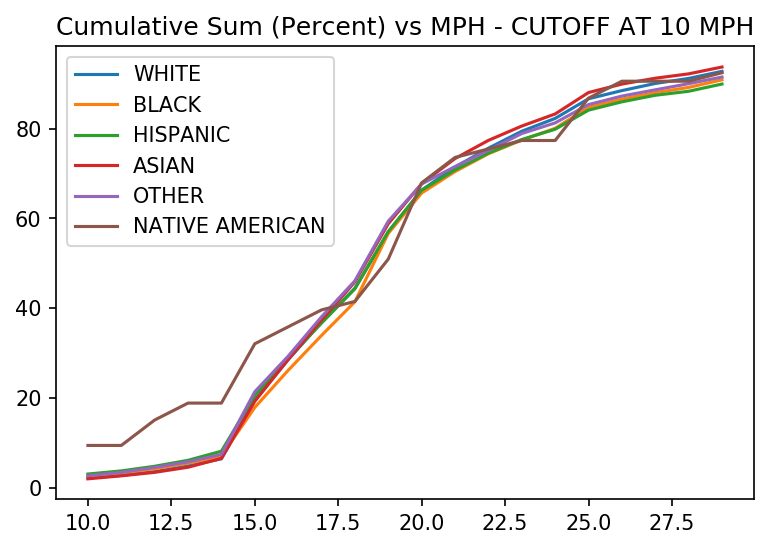

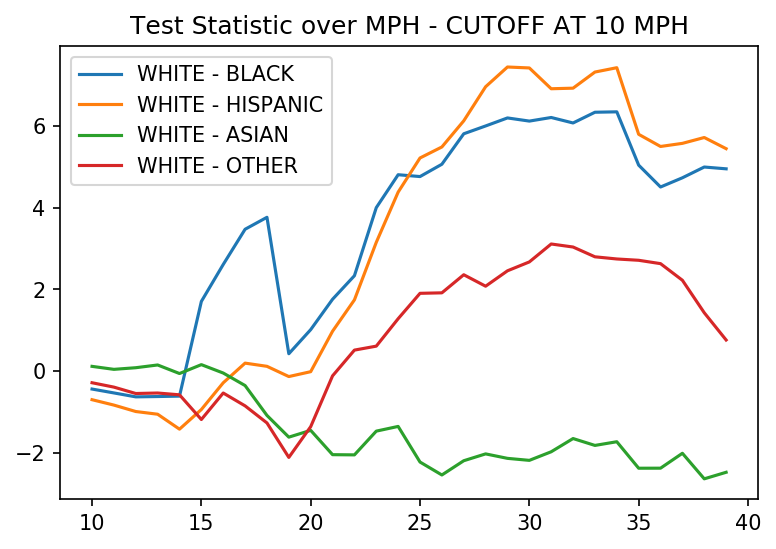

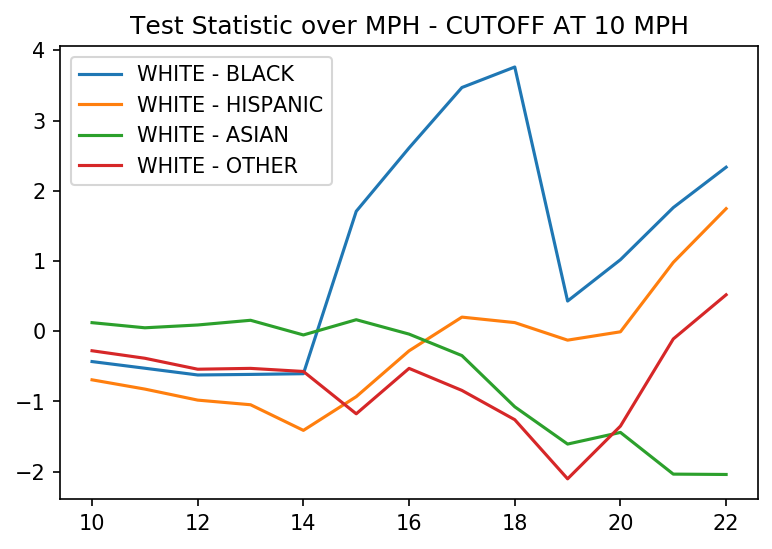

In [119]:
investigate_conditional_cutoff(10)

## Manually compute z stat between white-black at 25 mph

Just confirming that the table is computed correctly

In [58]:
#manually 
speeed = 15

white = 85.736955 / 100
black = 83.587288 / 100

white_n = generate_raw_count_df(df, speeed, 100).cumsum()['WHITE'][25]
black_n = generate_raw_count_df(df, speeed, 100).cumsum()['BLACK'][25]

numerator_l = white - black
denominator_l = np.sqrt( (white * (1-white))/white_n + (black * (1-black))/black_n )

numerator_l / denominator_l

#so the z_statistics are correct

4.989024657890541

# Conclusion

(White, Black); and (White, Hispanic) appear to have different distributions... except at 19,20 mph (and Hispanic-White at 21) (depends on cutoff)